In [1]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pickle
from tqdm import tqdm

# Path to your dataset
DATASET_PATH = r"D:\ML PROJECTS\Human Action Detection\archive"

# Settings
IMG_HEIGHT, IMG_WIDTH = 64, 64
FRAMES_PER_VIDEO = 30

# Output containers
X_data = []
y_labels = []

# Loop through all action folders
actions = os.listdir(DATASET_PATH)
for action in tqdm(actions, desc="Processing actions"):
    action_path = os.path.join(DATASET_PATH, action)
    
    for video_file in os.listdir(action_path):
        video_path = os.path.join(action_path, video_file)
        
        cap = cv2.VideoCapture(video_path)
        frames = []
        count = 0

        while cap.isOpened() and count < FRAMES_PER_VIDEO:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Optional: grayscale
            frames.append(frame)
            count += 1

        cap.release()

        # Only use videos with enough frames
        if len(frames) == FRAMES_PER_VIDEO:
            X_data.append(np.array(frames))
            y_labels.append(action)

# Convert to numpy arrays
X_data = np.array(X_data)
y_labels = np.array(y_labels)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_labels)

# Save preprocessed data
np.save("D:/ML PROJECTS/Human Action Detection/X_data.npy", X_data)
np.save("D:/ML PROJECTS/Human Action Detection/y_labels.npy", y_encoded)
with open("D:/ML PROJECTS/Human Action Detection/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("✅ Preprocessing done! Shapes:", X_data.shape, y_encoded.shape)


Processing actions: 100%|██████████| 6/6 [00:04<00:00,  1.32it/s]

✅ Preprocessing done! Shapes: (599, 30, 64, 64) (599,)


✅ Loaded shapes: (599, 30, 64, 64) (599,)


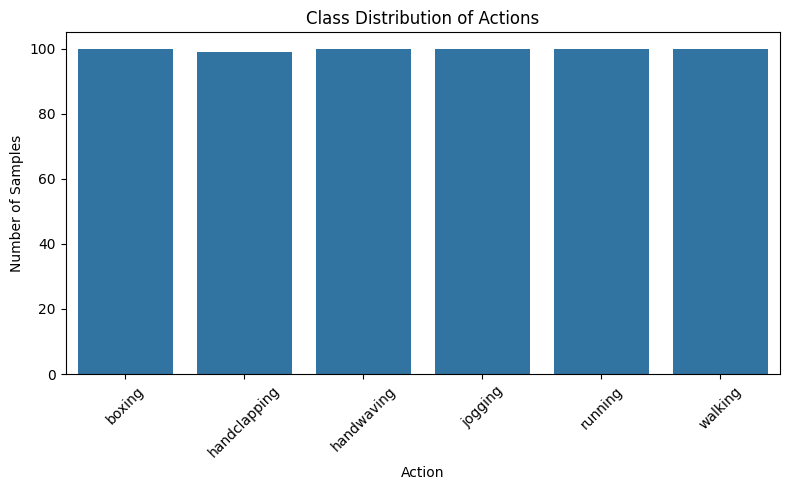

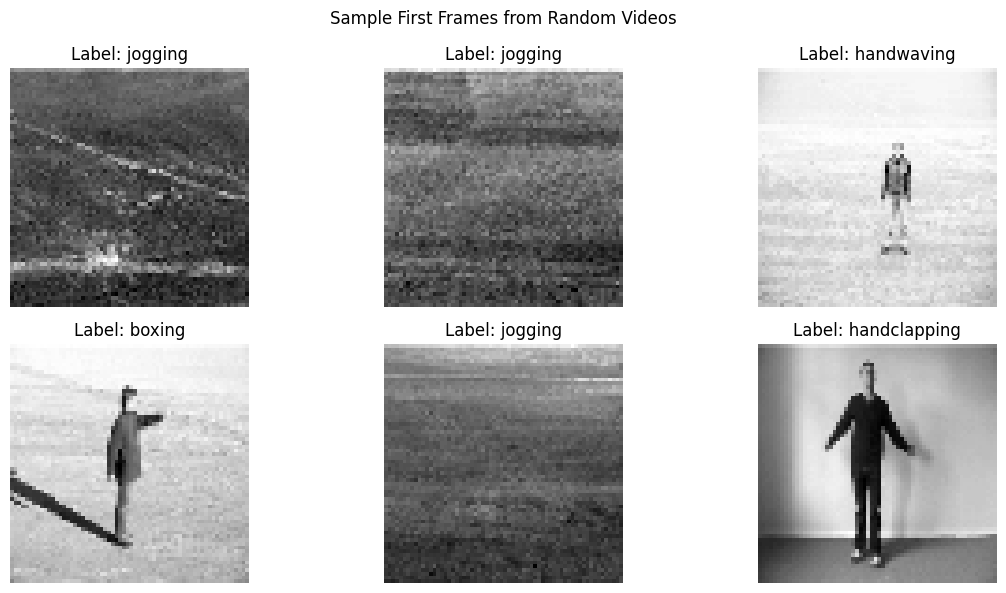

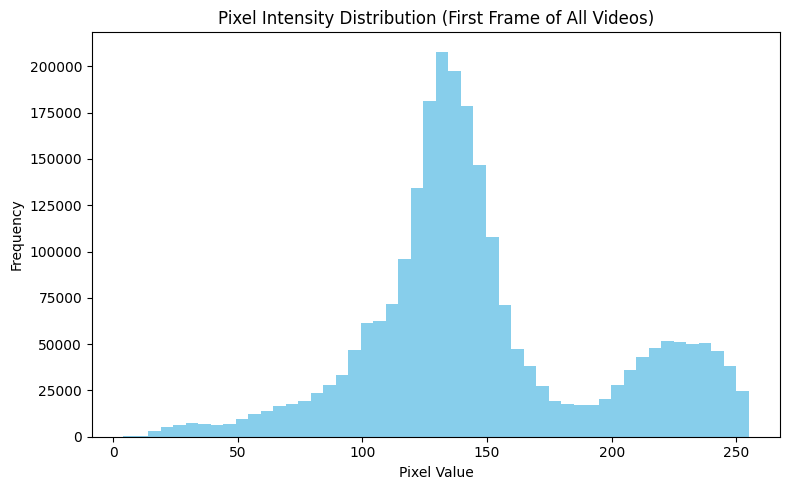

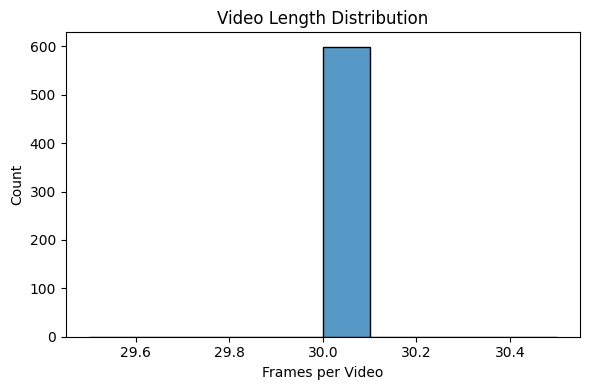

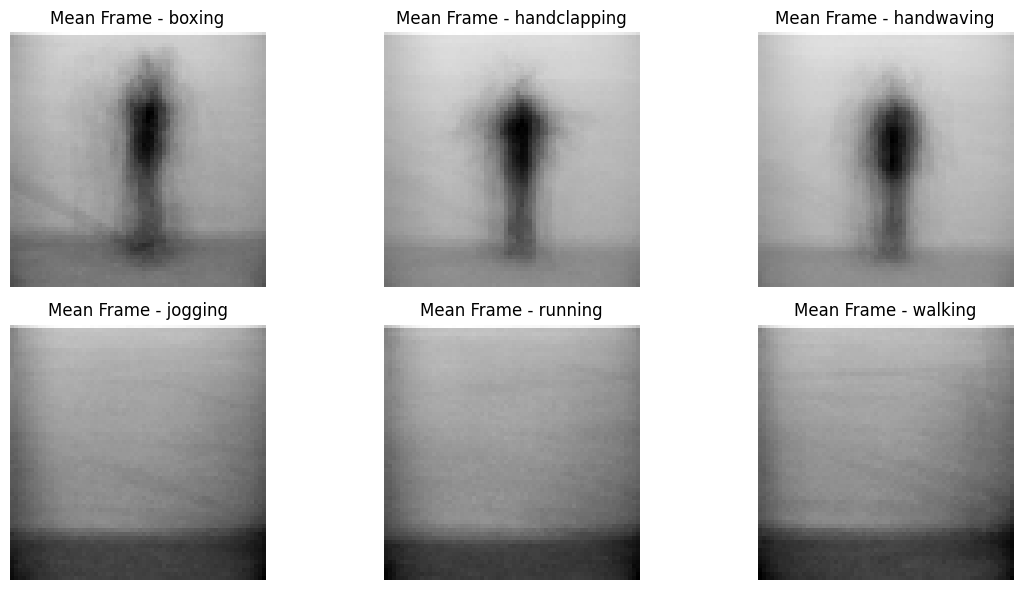

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import Counter
import random

# Load data
X = np.load("D:/ML PROJECTS/Human Action Detection/X_data.npy")
y = np.load("D:/ML PROJECTS/Human Action Detection/y_labels.npy")
with open("D:/ML PROJECTS/Human Action Detection/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

class_names = le.inverse_transform(np.unique(y))

print("✅ Loaded shapes:", X.shape, y.shape)

# --- 1. Class Distribution ---
plt.figure(figsize=(8, 5))
sns.countplot(x=le.inverse_transform(y))
plt.title("Class Distribution of Actions")
plt.xlabel("Action")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# [Leave space for IMAGE 1 in README]

# --- 2. Random Sample Frames ---
plt.figure(figsize=(12, 6))
for i in range(6):
    idx = random.randint(0, len(X) - 1)
    frame = X[idx][0]  # First frame of video
    label = le.inverse_transform([y[idx]])[0]
    plt.subplot(2, 3, i+1)
    plt.imshow(frame, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.suptitle("Sample First Frames from Random Videos")
plt.tight_layout()
plt.show()
# [Leave space for IMAGE 2 in README]

# --- 3. Pixel Intensity Histogram ---
plt.figure(figsize=(8, 5))
flattened = X[:, 0].reshape(len(X), -1).flatten()  # First frame of all videos
plt.hist(flattened, bins=50, color='skyblue')
plt.title("Pixel Intensity Distribution (First Frame of All Videos)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
# [Leave space for IMAGE 3 in README]

# --- 4. Video Length Consistency ---
frame_lengths = [video.shape[0] for video in X]
plt.figure(figsize=(6, 4))
sns.histplot(frame_lengths, bins=10, kde=False)
plt.title("Video Length Distribution")
plt.xlabel("Frames per Video")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
# [Leave space for IMAGE 4 in README]

# --- 5. Class-wise Average Frame ---
plt.figure(figsize=(12, 6))
for idx, class_idx in enumerate(np.unique(y)):
    class_videos = X[y == class_idx]
    mean_frame = np.mean(class_videos[:, 0], axis=0)  # Average of first frames
    plt.subplot(2, 3, idx + 1)
    plt.imshow(mean_frame, cmap='gray')
    plt.title(f"Mean Frame - {le.inverse_transform([class_idx])[0]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
# [Leave space for IMAGE 5 in README]


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten,
                                     LSTM, Dense, Dropout, BatchNormalization, Bidirectional,
                                     GlobalAveragePooling2D)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pickle

# Load Data
X = np.load("D:/ML PROJECTS/Human Action Detection/X_data.npy")
y = np.load("D:/ML PROJECTS/Human Action Detection/y_labels.npy")
with open("D:/ML PROJECTS/Human Action Detection/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# Normalize
X = X / 255.0

# One-hot encode labels
y_cat = to_categorical(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)

print("✅ Data split:", X_train.shape, X_test.shape)

# Add channel dimension
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Create base MobileNetV2 model
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(X.shape[2], X.shape[3], 3))
mobilenet.trainable = False  # Freeze to speed up training

# Since MobileNetV2 needs 3 channels, we tile grayscale to RGB
from tensorflow.keras.layers import Lambda
def repeat_channels(x): return tf.tile(x, [1, 1, 1, 3])  # 1 grayscale → 3 channels

# Build Model
model = Sequential([
    TimeDistributed(Lambda(repeat_channels), input_shape=X_train.shape[1:]),
    TimeDistributed(mobilenet),
    TimeDistributed(GlobalAveragePooling2D()),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train
history = model.fit(X_train, y_train, epochs=15, batch_size=16, validation_data=(X_test, y_test))

# Save model
model.save("D:/ML PROJECTS/Human Action Detection/human_action_model.h5")
print("✅ Model saved.")


✅ Data split: (479, 30, 64, 64) (120, 30, 64, 64)


C:\Users\yuvan\AppData\Local\Temp\ipykernel_22796\2970638286.py:34: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(X.shape[2], X.shape[3], 3))
c:\Users\yuvan\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_7              │ (None, 30, 64, 64, 3)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 30, 2, 2, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 30, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │       688,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,955,270 (11.27 MB)

 Trainable params: 697,286 (2.66 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.3205 - loss: 1.6288 - val_accuracy: 0.4333 - val_loss: 1.1608
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - accuracy: 0.5329 - loss: 1.0742 - val_accuracy: 0.5417 - val_loss: 1.0043
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 441ms/step - accuracy: 0.6942 - loss: 0.8055 - val_accuracy: 0.5917 - val_loss: 0.8987
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 453ms/step - accuracy: 0.7456 - loss: 0.6738 - val_accuracy: 0.6000 - val_loss: 0.8850
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 432ms/step - accuracy: 0.8010 - loss: 0.5595 - val_accuracy: 0.6583 - val_loss: 0.8602
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 430ms/step - accuracy: 0.8847 - loss: 0.3712 - val_accuracy: 0.6083 - val_loss: 0.8578
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 426ms/step - accuracy: 0.8953 - loss: 0.3518 - val_accuracy: 0.6417 - val_loss: 0.8567
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 422ms/step - accuracy: 0.9022 - loss: 0.2802 - val_accurac

✅ Model saved.


4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 8s/step 
✅ Classification Report:
               precision    recall  f1-score   support

      boxing       0.95      0.95      0.95        20
handclapping       0.81      0.85      0.83        20
  handwaving       0.79      0.75      0.77        20
     jogging       0.48      0.55      0.51        20
     running       0.56      0.50      0.53        20
     walking       0.63      0.60      0.62        20

    accuracy                           0.70       120
   macro avg       0.70      0.70      0.70       120
weighted avg       0.70      0.70      0.70       120



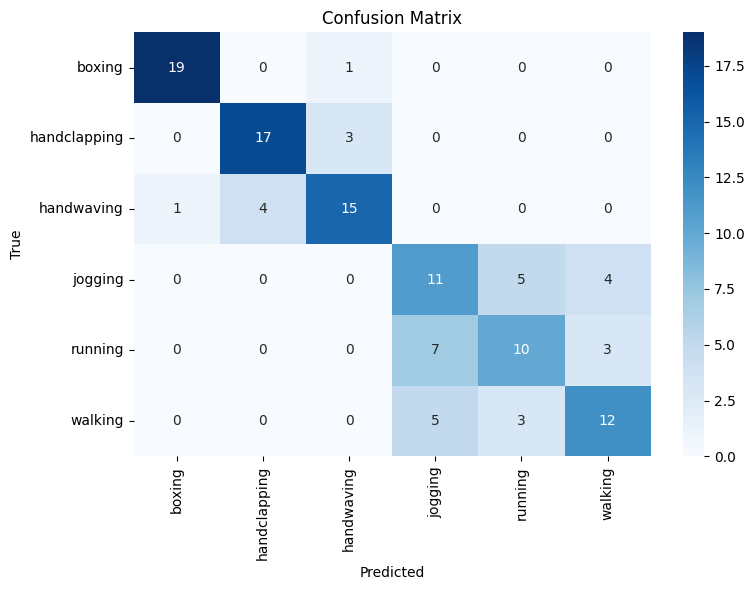

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
report = classification_report(y_true_classes, y_pred_classes, target_names=le.classes_)
print("✅ Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
